# Saving and Restoring

In this lesson you are going to save and restore your models for additional training.

> Tensorflow makes this [really easy](https://www.tensorflow.org/how_tos/variables/)

#### Create Saver object
* saver = tf.train.Saver()  

#### Save Model
* saver.save(sess, save_path)

#### Restore Model
* saver.restore(sess, save_path)

In [286]:
# import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn import preprocessing
import sys
import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot')  # use this plot style
%matplotlib inline

print('Python version ' + sys.version)
print('Tensorflow version ' + tf.VERSION)
print('Pandas version ' + pd.__version__)
print('Numpy version ' + np.__version__)

Python version 3.6.3 |Anaconda, Inc.| (default, Nov  3 2017, 12:34:11) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Tensorflow version 1.1.0
Pandas version 0.20.3
Numpy version 1.14.0


# Function to model

    y = a * x^8 - b * x^6  


> TIP: Recommended percentages  

* Training - ***70%***
* Validation - ***15%***
* Test - ***15%***

# Some Handy Functions  

Since my model was performing terribly, I attempted to pre-process my data to see if this would help me out. 

In [287]:
def normalize(array):
    u = array.mean()
    s = array.std()
    norm = (array - u)/s
    return u,s,norm

def min_max(array,min = 0, max = 1):
    X_std = (array - array.min(axis=0))/(array.max(axis=0) - array.min(axis=0))
    X_scaled = X_std * ( max - min ) + min
    return X_scaled

In [288]:
# Let's generate 10000 random samples
pool = np.random.rand(10000,1).astype(np.float32)

# Shuffle the samples
np.random.shuffle(pool)

# sample size of 15%
sample = int(1000 * 0.15)

# 15% test
test_x = pool[0:sample]

# 15% validation
valid_x = pool[sample:sample*2]

# 70% training
train_x = pool[sample*2:]

print('Testing data points: ' + str(test_x.shape))
print('Validation data points: ' + str(valid_x.shape))
print('Training data points: ' + str(train_x.shape))

# Let's compute the ouput using 2 for a and 2 for b
test_y = 2.0 * test_x**8 + 1.0 * test_x**6
valid_y = 2.0 * valid_x**8 + 1.0 * valid_x**6
train_y = 2.0 * train_x**8 + 1.0 * train_x**6

# 缩放x和y，由于x已经很接近0～1范围，所以只缩放y
test_y = min_max(test_y)
valid_y = min_max(valid_y)
train_y = min_max(train_y)

# Normalize x and y (I choose to only normalize y since x seemed already to be close enough to mean=0, std=1)
u_test_y,s_test_y,test_y = normalize(test_y)
u_valid_y,s_valid_y,valid_y = normalize(valid_y)
u_train_y,s_train_y,train_y = normalize(train_y)

Testing data points: (150, 1)
Validation data points: (150, 1)
Training data points: (9700, 1)


In [289]:
df = pd.DataFrame({'train_x':train_x[:,0],
                   'train_y':train_y[:,0]})

df_valid = pd.DataFrame({'valid_x':valid_x[:,0],
                   'valid_y':valid_y[:,0]})

df_test = pd.DataFrame({'test_x':test_x[:,0],
                   'test_y':test_y[:,0]})
df.head()

,train_x,train_y
0,0.121377,-0.546659
1,0.891677,1.400543
2,0.782506,0.217208
3,0.040775,-0.546664
4,0.442946,-0.530935


In [290]:
df.describe()

,train_x,train_y
count,9700.000000,9.700000e+03
mean,0.499236,-2.438260e-08
std,0.289537,1.000051e+00
min,0.000207,-5.466642e-01
25%,0.247132,-5.462818e-01
50%,0.499564,-5.118123e-01
75%,0.748820,1.275775e-02
max,0.999895,3.936933e+00


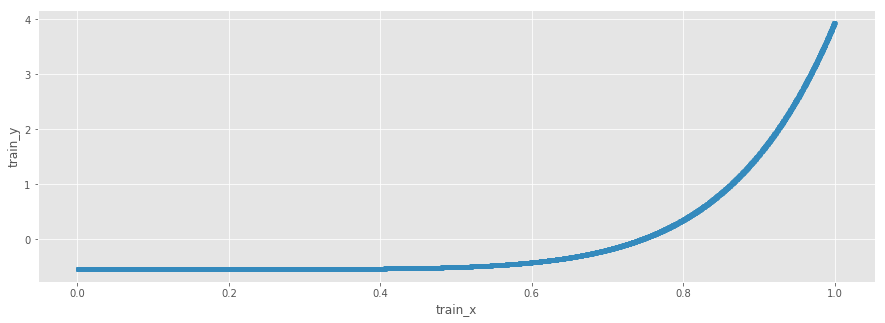

In [291]:
df.plot.scatter(x='train_x',y='train_y',figsize=(15,5))

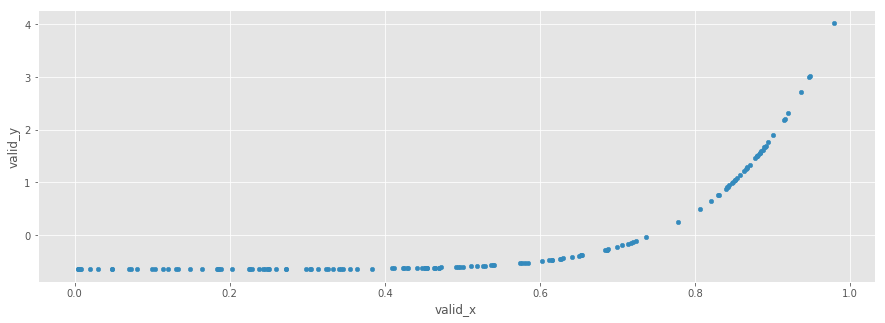

In [292]:
df_valid.plot.scatter(x='valid_x', y='valid_y', figsize=(15,5));

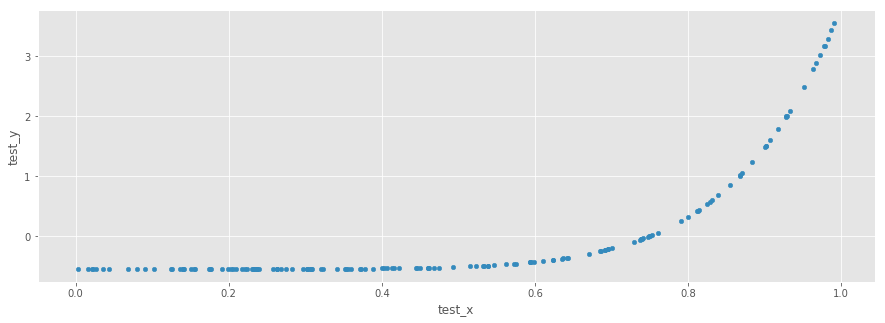

In [293]:
df_test.plot.scatter(x='test_x', y='test_y', figsize=(15,5));

# Helper Functions  

Make a function that will help you create layers easily

In [294]:
def add_layer(inputs, in_size, out_size, activation_function=None):
    
    # tf.random_normal([what is the size of your batches, size of output layer])
    Weights = tf.Variable(tf.truncated_normal([in_size, out_size], mean=0.1, stddev=0.1))
    
    # tf.random_normal([size of output layer])
    biases = tf.Variable(tf.truncated_normal([out_size], mean=0.1, stddev=0.1))
    
    # shape of pred = [size of your batches, size of output layer]
    pred = tf.matmul(inputs, Weights) + biases

    if activation_function is None:
        outputs = pred
    else:
        outputs = activation_function(pred)
    return outputs

# Model your Graph

Start to use W (for weight) and b (for bias) when setting up your variables. Aside from adding your ReLU activation function, it is a good idea to use Tensorflow's ***matrix multiplication function (matmul)*** as shown below.  

> The ? in the shape output just means it can be of any shape.

# Pick your Batch Size

In [295]:
# larger batch sizes help you get to the local minimum faster at a cost of more cpu power
# The strategy is to use batch_size when you cannot fit the entire dataset into memory
# In practice, small to moderate mini-batches (10-500) are generally used
batch_size = 100

# you can adjust the number of neurons in the hidden layers here
hidden_size = 10

# placeholders
# shape=[how many samples do you have, how many input neurons]
x = tf.placeholder(tf.float32, shape=[None, 1], name="01_x")
y = tf.placeholder(tf.float32, shape=[None, 1], name="01_y")

print("shape of x and y:")
print(x.get_shape(),y.get_shape())

shape of x and y:
(?, 1) (?, 1)


# Add Your Drop Out Placeholder  

We will be feeding in the percentage of neurons to keep on every epoch

In [296]:
# drop put
keep_prob = tf.placeholder(tf.float32)

In [297]:
# create your hidden layers!
h1 = add_layer(x, 1, hidden_size, tf.nn.relu)

# here is where we shoot down some of the neurons
h1_drop = tf.nn.dropout(h1, keep_prob)

# add a second layer
h2 = add_layer(h1_drop, hidden_size, hidden_size, tf.nn.relu)
h2_drop = tf.nn.dropout(h2, keep_prob)

# add a third layer
h3 = add_layer(h2_drop, hidden_size, hidden_size, tf.nn.relu)
h3_drop = tf.nn.dropout(h3, keep_prob)

# add a fourth layer
h4 = add_layer(h3_drop, hidden_size, hidden_size, tf.nn.relu)
h4_drop = tf.nn.dropout(h4, keep_prob)

print("shape of hidden layers:")
print(h1_drop.get_shape(), h2_drop.get_shape(), h3_drop.get_shape(), h4_drop.get_shape())

shape of hidden layers:
(?, 10) (?, 10) (?, 10) (?, 10)


In [298]:
# Output Layers
pred = add_layer(h4_drop, hidden_size, 1)

print("shape of output layer:")
print(pred.get_shape())

shape of output layer:
(?, 1)


In [299]:
# minimize the mean squared errors.
loss = tf.reduce_mean(tf.square(pred - y))

# pick optimizer
optimizer = tf.train.GradientDescentOptimizer(0.001)
train = optimizer.minimize(loss)

# Saving and Restoring Model

In [300]:
saver = tf.train.Saver()

save_path = './model_'+datetime.datetime.now().strftime("%Y-%m-%d")

# How Good is Your model?  

Set up the following variables to calculate the accuracy rate of your model. You will do that shortly.

In [301]:
# check accuracy of model
correct_prediction = tf.equal(tf.round(pred), tf.round(y))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [302]:
# Best validation accuracy seen so far.
best_valid_acc = 0.0

# Iteration-number for last improvement to validation accuracy.
last_improvement = 0

# Stop optimization if no improvement found in this many iterations.
require_improvement = 15000

# Training Time!  

The code below aims to save the best model you have seen during training. If an improvement is found, you save that model to disk. Also note that you can restore any saved model before you begin training so you can continue training a previosly saved model. Just make sure you have a saved model before running the restore code below. Note that saving your model constantly may ***slow down*** your training time.

> Where is my model getting saved?  

It should be inside the ***tmp*** folder.

In [303]:
# initialize the variables
init = tf.global_variables_initializer()

# hold step and error values
t = []

# Run your graph
with tf.Session() as sess:
    
    # restore model (no need to initialize variables if restorint model)
    saver.restore(sess, save_path=save_path)    
    
    # initialize variables
    sess.run(init)

    # Fit the function.
    for step in range(60000):
        
        # pull batches at random
        i = np.random.permutation(train_x.shape[0])[:batch_size]

        # get your data
        train_data = {x:train_x[i,:], y:train_y[i,:], keep_prob: 0.98}
        valid_data = {x:valid_x, y:valid_y, keep_prob: 1.0}
        test_data = {x:test_x, y:test_y, keep_prob: 1.0}
        
        # training in progress...
        train_loss, train_pred = sess.run([loss, train], feed_dict=train_data)        
        
        # print every n iterations
        if step%1000==0:
            # capture the step and error for analysis
            valid_loss = sess.run(loss, feed_dict=valid_data) 
            t.append((step, train_loss, valid_loss))    
            
            # get snapshot of current training and validation accuracy       
            train_acc = accuracy.eval(train_data)
            valid_acc = accuracy.eval(valid_data)           

            # If validation accuracy is an improvement over best-known.
            if valid_acc > best_valid_acc:
                # Update the best-known validation accuracy.
                best_valid_acc = valid_acc
                
                # Set the iteration for the last improvement to current.
                last_improvement = step
                
                # Save model to disk
                saver.save(sess, save_path=save_path)                

                # Flag when ever an improvement is found
                improved_str = '*'
            else:
                # An empty string to be printed below.
                # Shows that no improvement was found.
                improved_str = ''   
                
            print("step %d,train_acc:%f,valid_acc:%f,train_loss:%f,valid_loss:%f %s" % (step,train_acc,valid_acc,train_loss,valid_loss,improved_str))             
                
            # If no improvement found in the required number of iterations.
            if step - last_improvement > require_improvement:
                print("No improvement found in a while, stopping optimization.")

                # Break out from the for-loop.
                break                
            
            
    # here is where you see how good of a Data Scientist you are        
    print("Accuracy on the Training Set:", accuracy.eval(train_data) )
    print("Accuracy on the Validation Set:", accuracy.eval(valid_data) ) 
    print("Accuracy on the Test Set:", accuracy.eval(test_data) )
    
    # capture predictions on test data 
    test_results = sess.run(pred, feed_dict={x:test_x, keep_prob: 1.0})  
    df_final = pd.DataFrame({'test_x':test_x[:,0],
                             'pred':test_results[:,0]})
    
    # capture training and validation loss
    df_loss = pd.DataFrame(t, columns=['step', 'train_loss', 'valid_loss'])

INFO:tensorflow:Restoring parameters from ./model_2018-02-02


NotFoundError: Key Variable_151 not found in checkpoint
	 [[Node: save_15/RestoreV2_59 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_15/Const_0, save_15/RestoreV2_59/tensor_names, save_15/RestoreV2_59/shape_and_slices)]]

Caused by op 'save_15/RestoreV2_59', defined at:
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-300-8acc99a969e8>", line 1, in <module>
    saver = tf.train.Saver()
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1056, in __init__
    self.build()
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1086, in build
    restore_sequentially=self._restore_sequentially)
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 691, in build
    restore_sequentially, reshape)
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 669, in restore_v2
    dtypes=dtypes, name=name)
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/sunyufei/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Key Variable_151 not found in checkpoint
	 [[Node: save_15/RestoreV2_59 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_15/Const_0, save_15/RestoreV2_59/tensor_names, save_15/RestoreV2_59/shape_and_slices)]]
